In [1]:
import sys
import os
sys.path.append(os.path.abspath(".."))

In [2]:
# --- Imports ---
import time
import numpy as np
import matplotlib.pyplot as plt
from numf.numf import numf
from numf.peaks import get_neighbors
from numf.utils import initialize_matrices
from numf.multigrid import create_restriction_matrix, get_fine_indices

np.random.seed(42)


In [3]:
# --- Generate Toy Data ---
def gauss(x, sigma=1, mean=0, scale=1):
    """Returns a Gaussian curve."""
    return scale * np.exp(-np.square(x - mean) / (2 * sigma ** 2))

m = 100  
r = 3    # Number of components
p1, p2, p3 = 24, 50, 76  # Peak locations

x = np.arange(1, m + 1).reshape(-1, 1)
w1 = gauss(x, sigma=2, mean=p1)
w2 = np.concatenate((np.zeros((int((m - p2) / 2), 1)), np.ones((p2, 1)), np.zeros((int((m - p2) / 2), 1))))
w3 = gauss(x, sigma=2, mean=p3)
Wtrue = np.hstack((w1, w2, w3))

n = 6  # Number of features
c = 1 / np.sqrt(r - 1)
e = 0.001
Htrue = np.array([
    [c + e, 1 - c - e, 0],
    [1 - c - e, c + e, 0],
    [c + e, 0, 1 - c - e],
    [1 - c - e, 0, c + e],
    [0, c + e, 1 - c - e],
    [0, 1 - c - e, c + e]
]).T

M = Wtrue @ Htrue

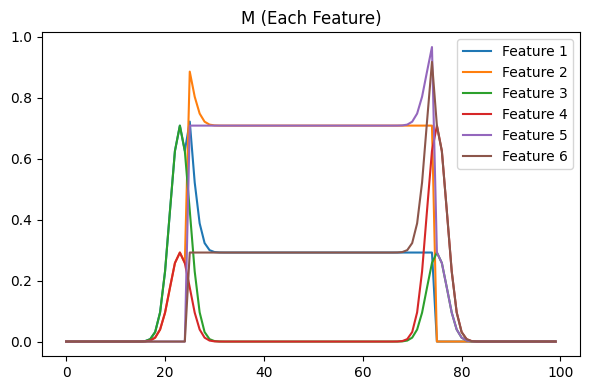

In [4]:
plt.figure(figsize=(6, 4))
for i in range(n):
    plt.plot(M[:, i], label=f'Feature {i+1}')
plt.title("M (Each Feature)")
plt.legend()
plt.tight_layout()
plt.show()

In [5]:
iters = 200
W0, H0 = initialize_matrices(m, n, r)

multigrid_results = {}
multigrid_times = {}

## Multigrid tests

In [6]:
# --- No Multigrid NuMF ---
print("### No Multigrid")
start = time.time()
W_nm, H_nm, _ = numf(M, W0.copy(), H0.copy(), iters=iters)
multigrid_results['No Multigrid'] = W_nm
multigrid_times['No Multigrid'] = time.time() - start


### No Multigrid
Total Iteration  200 | Final Loss: 0.107272


In [7]:
# --- Multigrid Level-1 ---
print("### Multigrid 1-Level")
R1 = create_restriction_matrix(m)
start = time.time()
_, H1, pouts1 = numf(R1 @ M, R1 @ W0.copy(), H0.copy(), iters=iters)
fine_pouts1 = get_fine_indices(pouts1)
W_mg1, H_mg1, _ = numf(M, W0.copy(), H1, pvals=get_neighbors(fine_pouts1, m, 3), iters=iters)
multigrid_results['Multigrid Level-1'] = W_mg1
multigrid_times['Multigrid Level-1'] = time.time() - start



### Multigrid 1-Level
Total Iteration  200 | Final Loss: 0.124850
Total Iteration  200 | Final Loss: 0.177173


In [8]:
# --- Multigrid Level-2 ---
R2 = create_restriction_matrix(R1.shape[0])
start = time.time()
_, H2, pouts2 = numf(R2 @ R1 @ M, R2 @ R1 @ W0.copy(), H0.copy(), iters=iters)
fine_pouts2 = get_fine_indices(pouts2, scaling_factor=4)
W_mg2, H_mg2, _ = numf(M, W0.copy(), H2, pvals=get_neighbors(fine_pouts2, m, 3), iters=iters)
multigrid_results['Multigrid Level-2'] = W_mg2
multigrid_times['Multigrid Level-2'] = time.time() - start



Total Iteration  200 | Final Loss: 0.112573
Total Iteration  200 | Final Loss: 0.182695


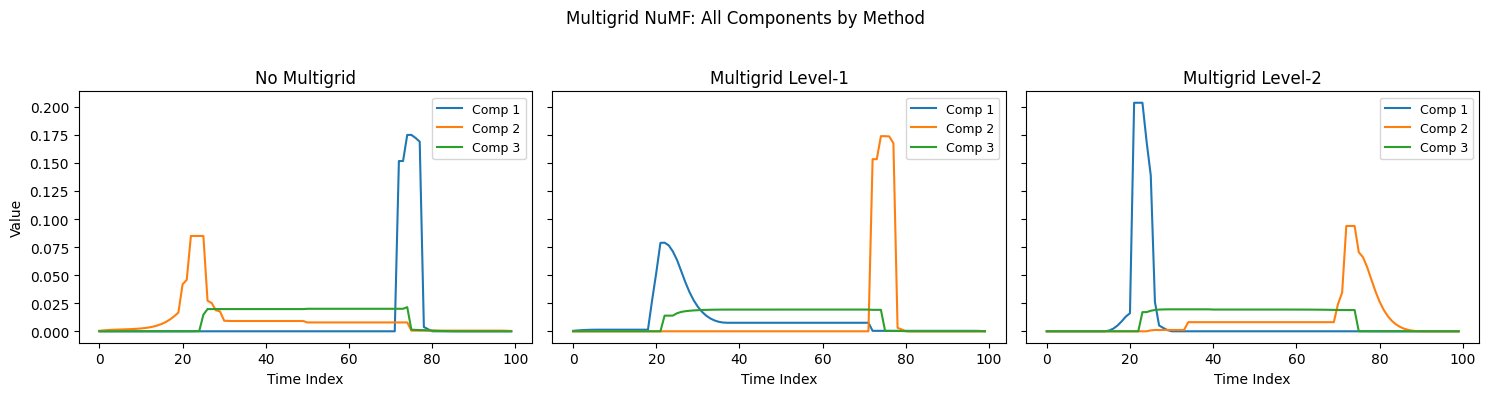

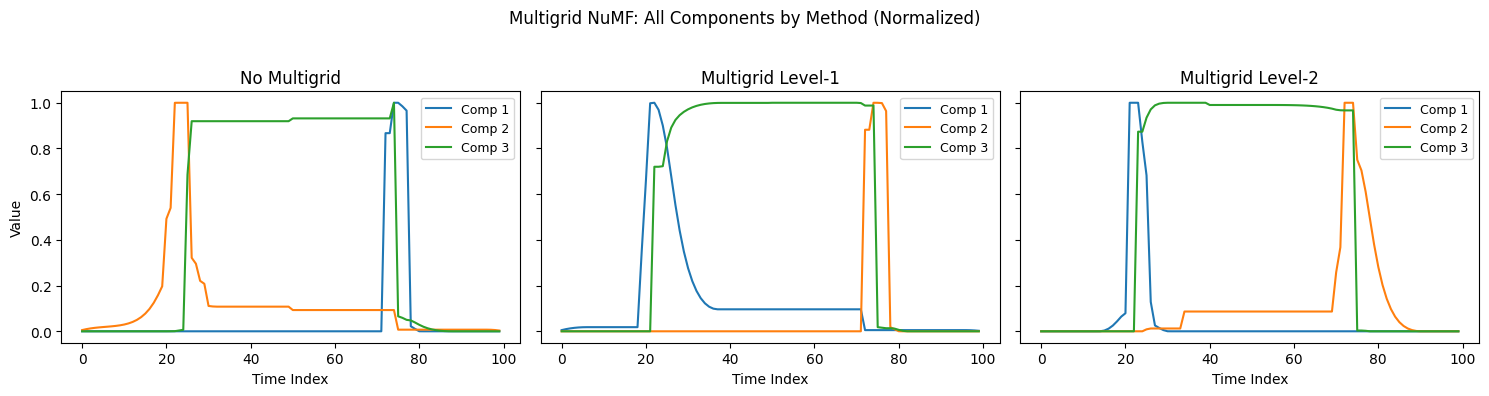

In [9]:
def plot_multigrid_dict(results_dict, r, normalize=False):
    keys = list(results_dict.keys())
    fig, axs = plt.subplots(1, len(keys), figsize=(5*len(keys), 4), sharex=True, sharey=True)
    if len(keys) == 1:
        axs = [axs]
    for j, key in enumerate(keys):
        W = results_dict[key]
        if normalize:
            W_plot = np.zeros_like(W)
            for i in range(r):
                maxval = np.max(np.abs(W[:, i]))
                W_plot[:, i] = W[:, i] / maxval if maxval != 0 else W[:, i]
        else:
            W_plot = W
        for i in range(r):
            axs[j].plot(W_plot[:, i], label=f'Comp {i+1}')
        axs[j].set_title(key)
        axs[j].set_xlabel("Time Index")
        if j == 0:
            axs[j].set_ylabel("Value")
        axs[j].legend(fontsize=9)
    plt.suptitle("Multigrid NuMF: All Components by Method" + (" (Normalized)" if normalize else ""))
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Plot unnormalized and normalized
plot_multigrid_dict(multigrid_results, r, normalize=False)
plot_multigrid_dict(multigrid_results, r, normalize=True)

In [10]:
# Print the keys and shapes of the multigrid results
for key, val in multigrid_times.items():
    print(f"{key}: {val:.2f} seconds")

No Multigrid: 15.16 seconds
Multigrid Level-1: 11.37 seconds
Multigrid Level-2: 8.91 seconds


## Regularization tests

In [11]:
print("### Regularization Test")
pvals = get_neighbors([p1, p2, p3], m, 5)

# l2 = 0
W_l20, H_l20, _ = numf(M, W0.copy(), H0.copy(), pvals=pvals, iters=iters, l2=0)


# l2 = 0.3
W_l23, H_l23, _ = numf(M, W0.copy(), H0.copy(), pvals=pvals, iters=iters, l2=0.3)


# l2 = 0.6
W_l26, H_l26, _ = numf(M, W0.copy(), H0.copy(), pvals=pvals, iters=iters, l2=0.6)

### Regularization Test
Total Iteration  200 | Final Loss: 0.098517
Total Iteration  200 | Final Loss: 0.262134
Total Iteration  200 | Final Loss: 0.298642


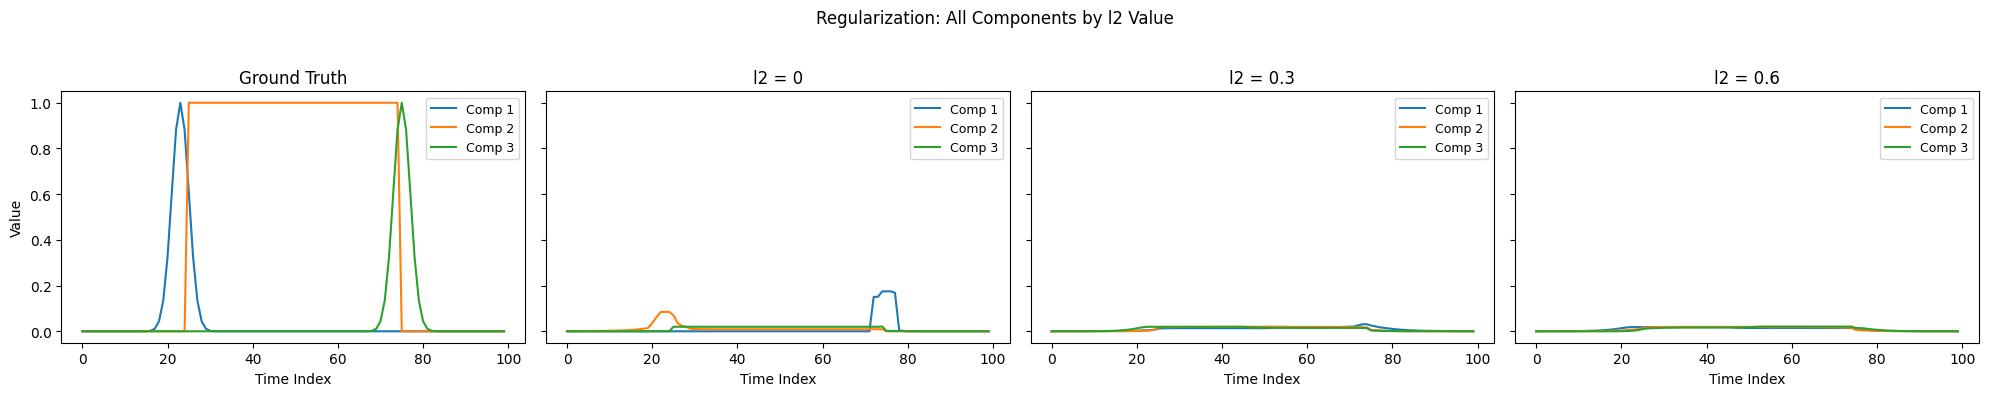

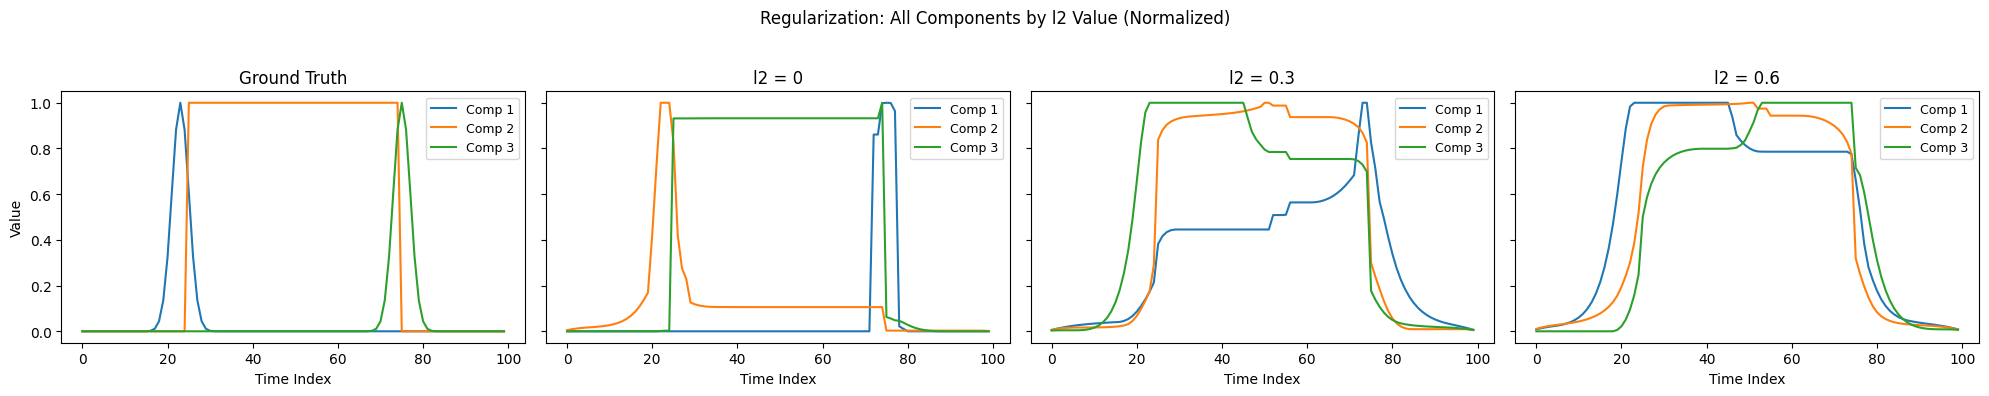

In [12]:
# --- Plot Regularization results: one subplot per l2 value, all components together ---
def plot_regularization_methods(Wtrue, W_l20, W_l23, W_l26, r, normalize=False):
    fig, axs = plt.subplots(1, 4, figsize=(20, 4), sharex=True, sharey=True)
    titles = ["Ground Truth", "l2 = 0", "l2 = 0.3", "l2 = 0.6"]
    Ws = [Wtrue, W_l20, W_l23, W_l26]
    for j, (ax, W, title) in enumerate(zip(axs, Ws, titles)):
        if normalize:
            # Normalize each component (column) independently
            W_plot = np.zeros_like(W)
            for i in range(r):
                maxval = np.max(np.abs(W[:, i]))
                W_plot[:, i] = W[:, i] / maxval if maxval != 0 else W[:, i]
        else:
            W_plot = W
        for i in range(r):
            ax.plot(W_plot[:, i], label=f'Comp {i+1}')
        ax.set_title(title)
        ax.set_xlabel("Time Index")
        if j == 0:
            ax.set_ylabel("Value")
        ax.legend(fontsize=9)
    plt.suptitle("Regularization: All Components by l2 Value" + (" (Normalized)" if normalize else ""))
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Plot original (unnormalized)
plot_regularization_methods(Wtrue, W_l20, W_l23, W_l26, r, normalize=False)

# Plot normalized
plot_regularization_methods(Wtrue, W_l20, W_l23, W_l26, r, normalize=True)